In [ ]:
!pip install tensorflow==2.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np

import os 
import tensorflow as tf

DATASET_PATH = '/content/drive/MyDrive/vant/exploring/testing_disease_dataset/plant_leaf_disease_scripted'
BATCH_SIZE = 40
IMG_SIZE = (299, 299)

disease_dataset = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                             shuffle=True,
                                                             batch_size=BATCH_SIZE,
                                                             color_mode='rgb',
                                                             image_size=IMG_SIZE,
                                                             crop_to_aspect_ratio=False,
                                                             )
disease_dataset

Found 200 files belonging to 2 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
leaves_dataset_lenght = disease_dataset.cardinality().numpy()

train_dataset = disease_dataset.take(leaves_dataset_lenght//4 * 3)
#train_dataset = train_dataset.unbatch().batch(BATCH_SIZE)

validation_dataset = disease_dataset.skip(leaves_dataset_lenght//4 *3)
#validation_dataset = leaves_dataset.unbatch().batch(BATCH_SIZE)

In [ ]:
def image_standardization(image,label):
  """image = tf.image.per_image_standardization(image)"""
  image = tf.math.subtract(image, tf.math.reduce_mean(image))
  return image, label

train_dataset = train_dataset.map(image_standardization)
validation_dataset = validation_dataset.map(image_standardization)

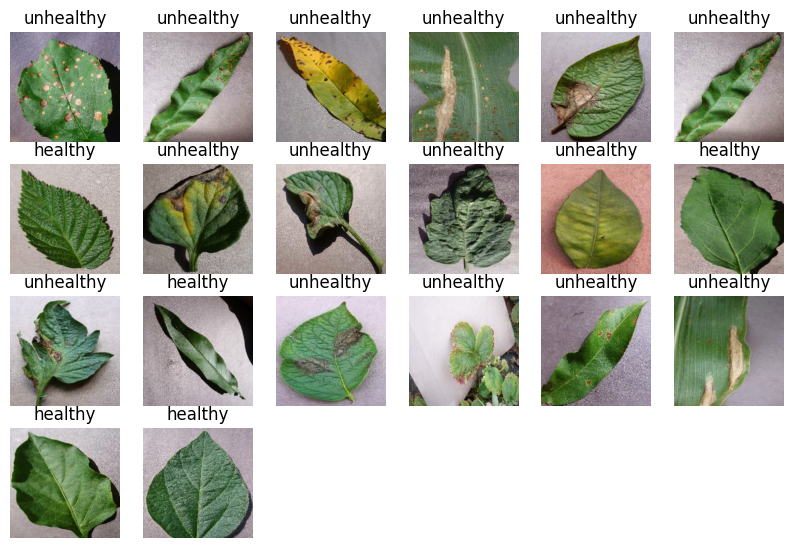

In [ ]:
import matplotlib.pyplot as plt

class_names = disease_dataset.class_names

plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
  for i in range(20):
    ax = plt.subplot(6, 6, i + 1)
    img = tf.keras.utils.array_to_img(images[i].numpy())
    plt.imshow(img)
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 2
Number of test batches: 1


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

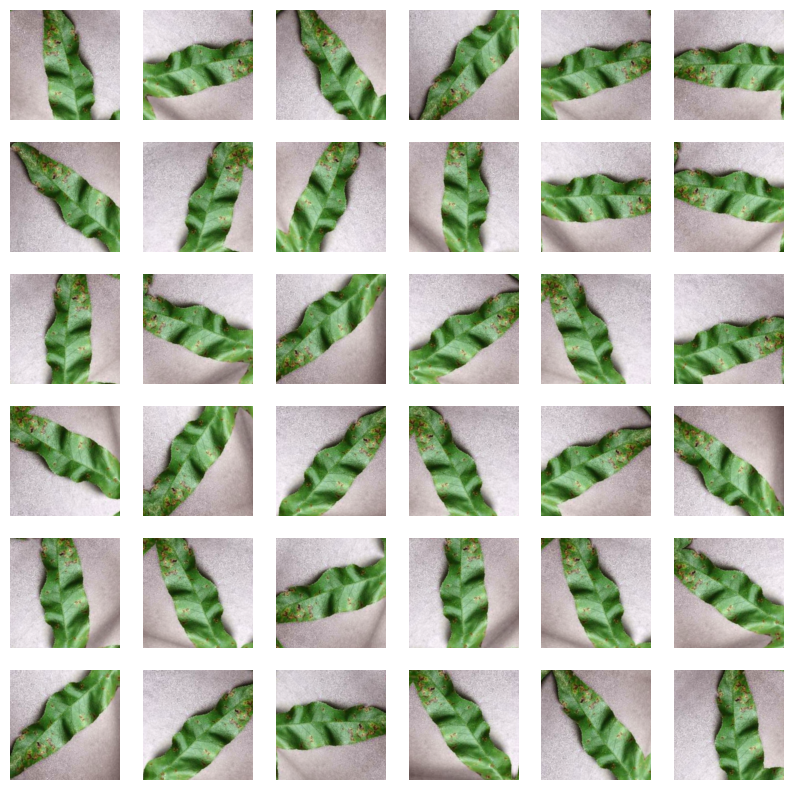

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(244, 244),
  tf.keras.layers.Resizing(IMG_SIZE[0], IMG_SIZE[1]),
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation((-0.2, 0.3)),
])

for image, _ in test_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(36):
    ax = plt.subplot(6, 6, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True) # tf.expand_dims() é só pro sample ser tratado como um batch (160,160,3) -> (1,160,160,3)
    
    img = tf.keras.utils.array_to_img(augmented_image[0])

    plt.imshow(img)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.xception.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset)) # next(iter()) parece uma fila.
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(40, 10, 10, 2048)


In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

prediction_layer = tf.keras.layers.Dense(11, activation='softmax',
                                         kernel_regularizer=tf.keras.regularizers.L1(1e-3),
                                         activity_regularizer=tf.keras.regularizers.L2(1e-2)
                                         )


prediction_batch = prediction_layer(feature_batch)

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0007
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [ ]:
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


2/2 [==============================] - 5s 285ms/step - loss: 2.9973 - accuracy: 0.1375
initial loss: 3.00
initial accuracy: 0.14


In [ ]:
print(model.evaluate(test_dataset))

1/1 [==============================] - 1s 949ms/step - loss: 3.0493 - accuracy: 0.1000
[3.0493195056915283, 0.10000000149011612]


In [ ]:
initial_epochs = 30

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/30
3/3 [==============================] - 6s 903ms/step - loss: 2.6617 - accuracy: 0.3417 - val_loss: 2.2833 - val_accuracy: 0.4625
Epoch 2/30
3/3 [==============================] - 4s 1s/step - loss: 2.0732 - accuracy: 0.5250 - val_loss: 1.8203 - val_accuracy: 0.5500
Epoch 3/30
3/3 [==============================] - 3s 905ms/step - loss: 1.6761 - accuracy: 0.5167 - val_loss: 1.5844 - val_accuracy: 0.5375
Epoch 4/30
3/3 [==============================] - 3s 910ms/step - loss: 1.4917 - accuracy: 0.5583 - val_loss: 1.4476 - val_accuracy: 0.6125
Epoch 5/30
3/3 [==============================] - 3s 909ms/step - loss: 1.3764 - accuracy: 0.6667 - val_loss: 1.4083 - val_accuracy: 0.5250
Epoch 6/30
3/3 [==============================] - 3s 948ms/step - loss: 1.3232 - accuracy: 0.6833 - val_loss: 1.2813 - val_accuracy: 0.6500
Epoch 7/30
3/3 [==============================] - 3s 900ms/step - loss: 1.2524 - accuracy: 0.7083 - val_loss: 1.2529 - val_accuracy: 0.6750
Epoch 8/30
3/3 [=======

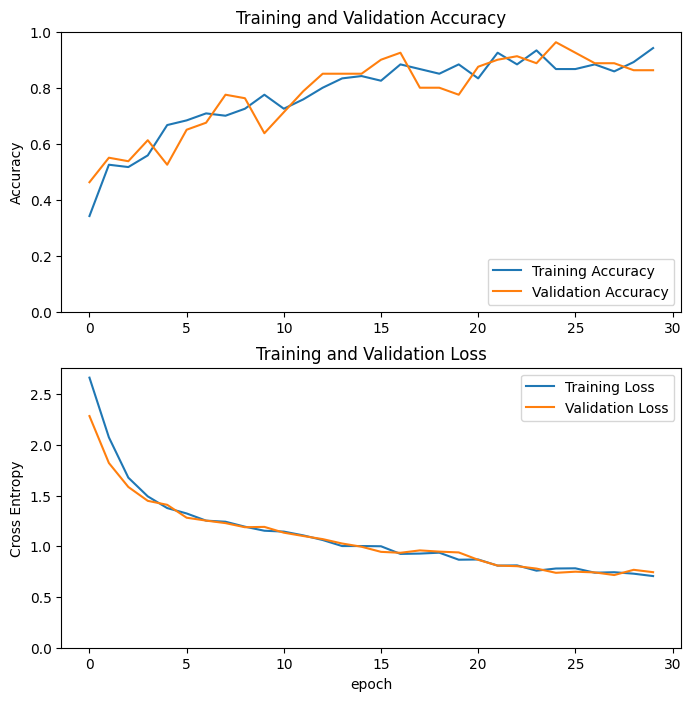

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.evaluate(test_dataset)

1/1 [==============================] - 1s 942ms/step - loss: 0.6675 - accuracy: 0.9250


[0.6674679517745972, 0.925000011920929]

In [ ]:
from sklearn.metrics import classification_report
for images, labels in test_dataset.unbatch().batch(616).take(1):
  y_pred = np.argmax(model.predict(images), axis=1)
  print(classification_report(labels.numpy(), y_pred, target_names=class_names))

              precision    recall  f1-score   support

     healthy       0.95      0.82      0.88        22
   unhealthy       0.81      0.94      0.87        18

    accuracy                           0.88        40
   macro avg       0.88      0.88      0.87        40
weighted avg       0.89      0.88      0.88        40



In [ ]:
for i in range(len(base_model.layers)):
  layer = base_model.layers[i]
  print(layer.name)